# Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.


### Loading the data


In [64]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [30]:
dataset = pd.read_csv('data/housing.csv')
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [31]:
data = dataset[['latitude',
                'longitude',
                'housing_median_age',
                'total_rooms',
                'total_bedrooms',
                'population',
                'households',
                'median_income',
                'median_house_value',
                'ocean_proximity']].copy()

In [32]:
features = ['latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'ocean_proximity']

In [33]:
data.fillna(0, inplace=True)

In [34]:
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(data, test_size=0.2, random_state=1)

In [35]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [36]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [37]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [38]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict('records')
X_train = dv.fit_transform(train_dict)

In [39]:
val_dict = df_val.to_dict('records')
test_dict = df_test.to_dict('records')
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

In [41]:
dtr_model = DecisionTreeRegressor(max_depth=1)
dtr_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [42]:
print(export_text(dtr_model, feature_names=list(dv.get_feature_names())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



**Answer: ocean_proximity=INLAND**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

In [43]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [44]:
rfr_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [45]:
round(rmse(y_val, rfr_model.predict(X_val)), 2)

0.24

**Answer: 0.25**

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 55
- 75
- 150


In [53]:
n_estimators = list(range(10, 201, 10))
scores = []
for n in n_estimators:
    rfr_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfr_model.fit(X_train, y_train)
    scores.append(round(rmse(y_val, rfr_model.predict(X_val)), 3))
    

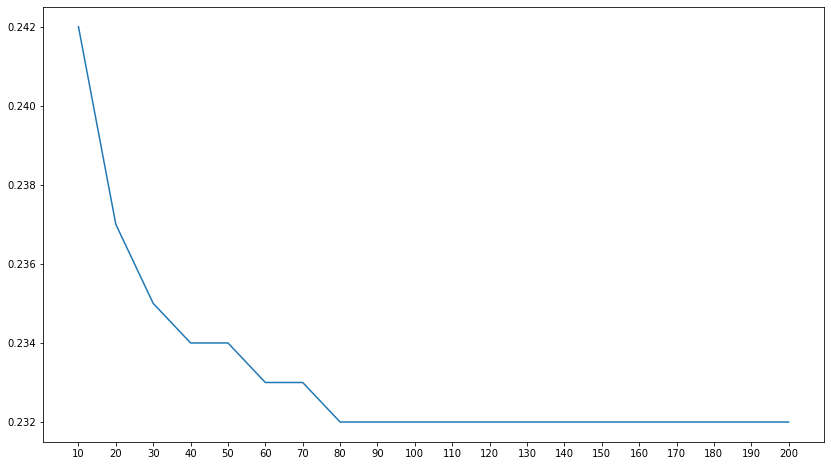

In [54]:
plt.figure(figsize=(14,8))
plt.plot(n_estimators, scores)
plt.xticks(n_estimators);

**Answer: 75**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [55]:
n_estimators = list(range(10, 201, 10))
max_depths = [10, 15, 20, 25]
scores = {}
for d in max_depths:
    score = []
    for n in n_estimators:
        rfr_model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rfr_model.fit(X_train, y_train)
        score.append(round(rmse(y_val, rfr_model.predict(X_val)), 3))
    scores[d] = max(score)

In [56]:
scores

{10: 0.258, 15: 0.244, 20: 0.243, 25: 0.241}

**Answer: 25**

## Question 5


We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [59]:
rfr_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [63]:
dv.get_feature_names()[np.argmax(rfr_model.feature_importances_)]

'median_income'

**Answer: median_income**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same


In [65]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [73]:
scores = {}
for eta in [0.3, 0.1, 0.01]:
    xgb_params = {  
                'eta': eta,  
                'max_depth': 6,  
                'min_child_weight': 1,  

                'objective': 'reg:squarederror',
                'nthread': 8,

                'seed': 1,
                'verbosity': 1,
                }
                
    xgb_model =  xgb.train(xgb_params, dtrain, 100)
    pred = xgb_model.predict(dval)
    scores[eta] = round(rmse(y_val, pred), 3)
scores

{0.3: 0.229, 0.1: 0.231, 0.01: 4.247}

**Answer: 0.3**